In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import time
import numpyro
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS
numpyro.set_platform("cpu")
numpyro.set_host_device_count(1)
import jax
import jax.numpy as jnp

import numpy as np
from typing import Sequence
from functools import reduce
from itertools import permutations

# flax related imports
from jax.tree_util import tree_map, tree_flatten, tree_unflatten
import flax.linen as nn
from flax.core import freeze, unfreeze

from data import datasets
import visualization

rng_key = jax.random.PRNGKey(0)
print(jax.local_device_count())

1


# Load Dataset

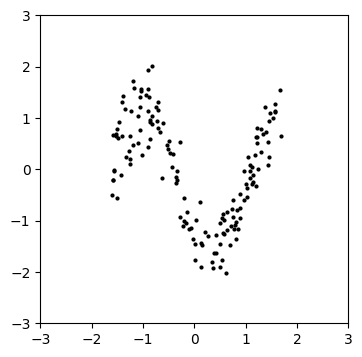

In [4]:
rng_key, rng_key_ = jax.random.split(rng_key)
dataset = datasets.Sinusoidal(normalization="standardization", rng_key=rng_key_, x_lower=0.0, x_upper=8.0)
X, y = dataset[:]

# visualization
visualization.RegressionFigure().plot(data=dataset.data)

# Flax Neural Network

In [5]:
class MLP(nn.Module):
    features: Sequence[int]
    
    @nn.compact
    def __call__(self, x):
        for i, feature in enumerate(self.features[:-1]):
            x = nn.tanh(nn.Dense(feature, use_bias=True, bias_init=nn.initializers.zeros, name=f"dense_{i}")(x))
        x = nn.Dense(self.features[-1], bias_init=nn.initializers.zeros, name=f"dense_{i + 1}")(x)
        return x
    
    ### predefined methods ###
    # def init()
    # def apply()
    
    ### from here: custom methods ###
    def init_from_vector(self, inputs, parameters_vector):
        parameters = self.init(jax.random.PRNGKey(0), inputs)  # I do not need random behaviour here.
        leaves, treedef = tree_flatten(parameters)
        new_leaves = []
        accumulator = 0
        for leaf in leaves:
            size = reduce(lambda x, y: x * y, [s for s in leaf.shape])
            new_leaves.append(parameters_vector[accumulator:accumulator + size].reshape(leaf.shape))
            accumulator += size
        new_parameters = tree_unflatten(treedef, new_leaves)
        return new_parameters
    
    def apply_from_vector(self, inputs, parameters):
        v = self.init_from_vector(inputs=inputs, parameters_vector=parameters)
        return self.apply(v, inputs)
    
    def parameters_size(self, inputs):
        parameters = self.init(jax.random.PRNGKey(0), inputs)
        leaves, treedef = tree_flatten(parameters)
        l = sum([reduce(lambda x, y: x * y, leaf.shape) for leaf in leaves])
        return l

In [6]:
neural_network = MLP([3, 1])

## Parameters Dictionary

In [5]:
rng_key, rng_key_ = jax.random.split(rng_key)
parameters = neural_network.init(rng_key_, X[0])
print(parameters)

FrozenDict({
    params: {
        dense_0: {
            kernel: DeviceArray([[0.25883198, 0.04052606, 0.08950225]], dtype=float32),
            bias: DeviceArray([0., 0., 0.], dtype=float32),
        },
        dense_1: {
            kernel: DeviceArray([[0.9898608 ],
                         [0.42035756],
                         [0.53037566]], dtype=float32),
            bias: DeviceArray([0.], dtype=float32),
        },
    },
})


In [6]:
outputs = neural_network.apply(parameters, X[0:10])
print(outputs.shape)
print(outputs)

(10, 1)
[[ 0.20842236]
 [-0.16592112]
 [ 0.3168732 ]
 [ 0.38228425]
 [ 0.35271716]
 [-0.3842113 ]
 [-0.22756818]
 [-0.24592954]
 [ 0.33070797]
 [ 0.2637462 ]]


## Parameters Vector

In [7]:
rng_key, rng_key_ = jax.random.split(rng_key)
parameters = jax.random.normal(rng_key_, (neural_network.parameters_size(X[0]), ))
print(parameters)

[ 0.13582012  0.09055769 -0.400528    0.09743893 -0.14248845  1.3772235
  1.9287591  -0.10041199  0.4329003   0.21801567]


In [8]:
outputs = neural_network.apply_from_vector(inputs=X[0:10], parameters=parameters)
print(outputs.shape)
print(outputs)

(10, 1)
[[2.0087807]
 [1.815063 ]
 [2.0475225]
 [2.0545034]
 [2.0526536]
 [1.8281257]
 [1.8121063]
 [1.8125339]
 [2.0499074]
 [2.0331433]]


## vmap() usecase

In [9]:
rng_key, rng_key_ = jax.random.split(rng_key)
parameters = jax.random.normal(rng_key_, (16, neural_network.parameters_size(X[0])))
print(parameters.shape)

(16, 10)


In [10]:
outputs = jax.vmap(fun=neural_network.apply_from_vector, in_axes=(None, 0))(X[0:10], parameters)
print(outputs.shape)
print(outputs[:2], "...")

(16, 10, 1)
[[[ 0.34330314]
  [ 1.8280746 ]
  [-0.16171992]
  [-0.41249532]
  [-0.30637372]
  [ 2.2801309 ]
  [ 2.0222983 ]
  [ 2.0730028 ]
  [-0.21947575]
  [ 0.07782412]]

 [[ 0.36613557]
  [-0.08162174]
  [ 0.21152732]
  [ 0.15037295]
  [ 0.17510435]
  [ 0.18471876]
  [-0.03764096]
  [-0.01218921]
  [ 0.19660106]
  [ 0.27927598]]] ...


# Probabilistic Model

In [11]:
def model(transformation, X, y, parameters_size):
    # priors
    parameters = numpyro.sample("parameters", dist.MultivariateNormal(jnp.zeros(parameters_size), jnp.eye(parameters_size)))
    logstd = numpyro.sample("logstd", dist.HalfNormal(1.0))
    
    # mean transformation
    means = transformation(inputs=X, parameters=parameters)
    
    # observe data
    with numpyro.plate("data", size=X.shape[0], dim=-2):
        return numpyro.sample("outputs", dist.Normal(means, logstd), obs=y)

# Inference

In [12]:
def infer(rng_key, model, neural_network, X, y):
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=512, num_samples=256, num_chains=16, progress_bar=True)
    mcmc.run(rng_key, neural_network.apply_from_vector, X, y, neural_network.parameters_size(X[0]))
    return mcmc.get_samples()

# Run

In [13]:
rng_key, rng_key_ = jax.random.split(rng_key)
samples_parameters = infer(rng_key_, model, neural_network, X, y)["parameters"]

/tmp/ipykernel_31/3974922611.py:3: UserWarning: There are not enough devices to run parallel chains: expected 16 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(16)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=512, num_samples=256, num_chains=16, progress_bar=True)
sample: 100%|██| 768/768 [00:01<00:00, 470.35it/s, 127 steps of size 4.16e-02. acc. prob=0.91]


# Remove Symmetries

In [7]:
from utils import MLPSymmetryHelper

sh = MLPSymmetryHelper(
    parameters_shapes=unfreeze(tree_map(lambda x: np.array(x.shape), neural_network.init_from_vector(inputs=X[0], parameters_vector=samples_parameters[0]))),
    activation_function="tanh"
)
activation_symmetries = sh.activation_symmetries()
permutation_symmetries = sh.permutation_symmetries()

NameError: name 'samples_parameters' is not defined

In [ ]:
print(activation_symmetries[1:2])
print(permutation_symmetries[1:2])

In [16]:
samples_parameters_mirrored = samples_parameters
samples_parameters_mirrored = sh.remove_tanh_symmetries(samples_parameters_mirrored, bias=False)
samples_parameters_mirrored = sh.remove_permutation_symmetries(samples_parameters_mirrored, bias=True)

# Visualization

100%|█████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]


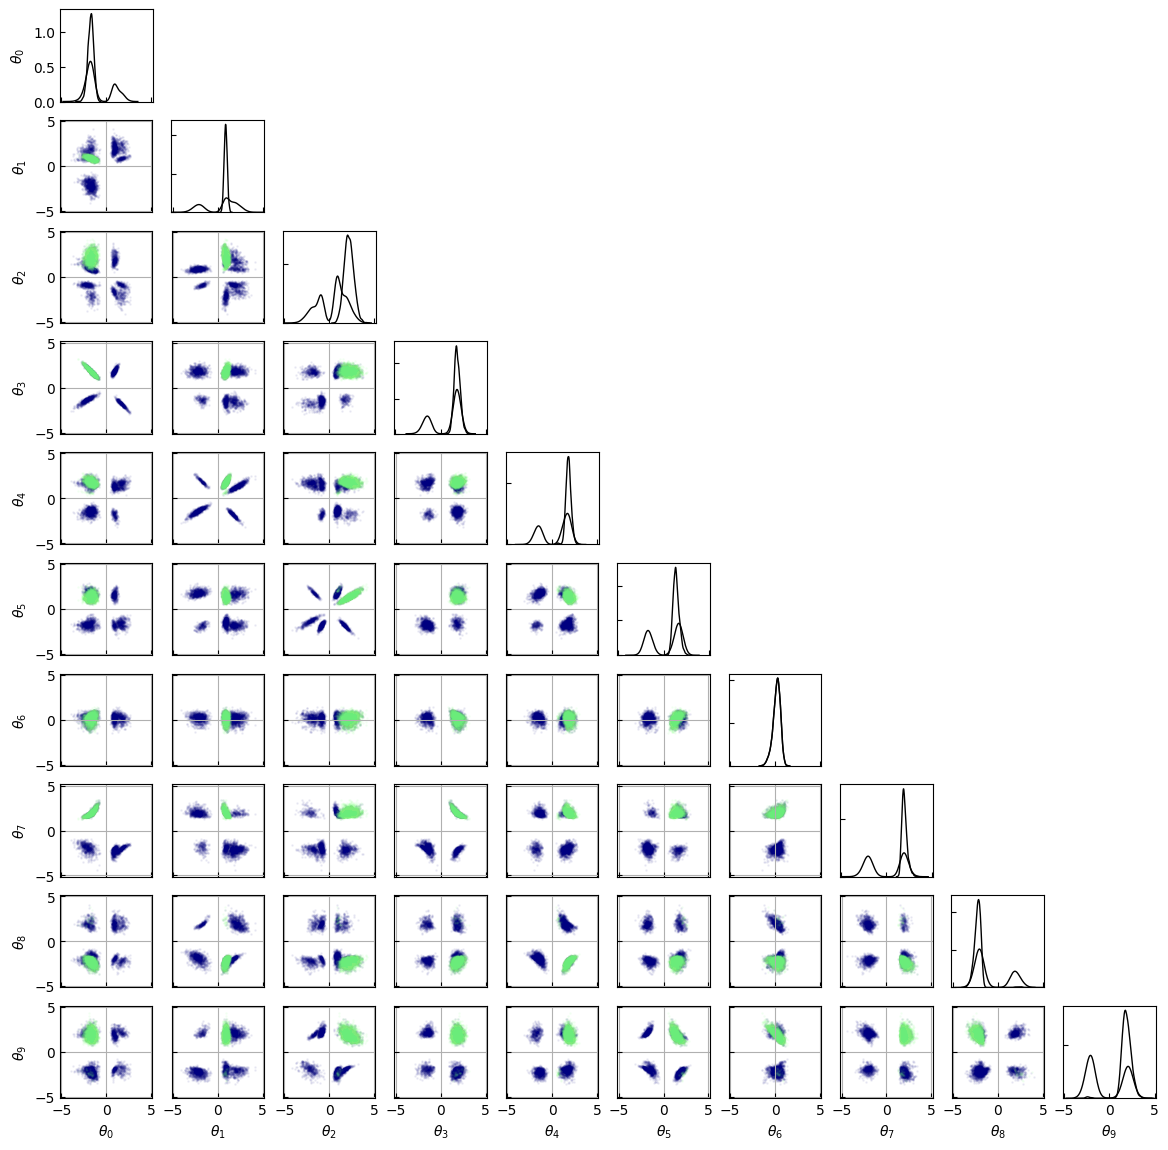

In [17]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=0.05, size=1.0)
    )
)
figure.plot(data_list=[samples_parameters, samples_parameters_mirrored])

In [18]:
figure = visualization.RegressionFigure(
    settings=visualization.RegressionSettings(
        transformation_plot_settings=visualization.TransformationPlotSettings(alpha=0.1)
    )
)
figure.plot(data=dataset.data, transformation=neural_network.apply_from_vector, parameters=samples_parameters_mirrored570570[:32], std=0.1)

NameError: name 'samples_parameters_mirrored570570' is not defined